In [1518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [1519]:
data = pd.read_excel("owid-covid-data.xlsx")
italy_data = data[data['location'] == "Italy"]
#rename for prophet
italy_data.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
#drop missing values
italy_data['ds'] = pd.to_datetime(italy_data['ds'])
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
italy_data = italy_data[~italy_data['ds'].isin(pd.to_datetime(dates_to_drop))]
italy_data.head()

## Data Prep

In [1520]:
# drop iso_code, contient, and location as the are not relevant
italy_data = italy_data.drop(['iso_code', 'continent', 'location'], axis=1)
# drop total_cases since it is new_cases accumulated
italy_data = italy_data.drop(['total_cases', 'total_cases_per_million'], axis=1)

In [1521]:
# since we are focusing on country level, remove features with more than 30% missingness
missing_percentage = italy_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 30].index
italy_data.drop(columns=columns_to_drop, inplace=True)
# remove quasi-constant features with more than 98% same values
#Removing quasi-constant features
from sklearn.feature_selection import VarianceThreshold
italy_data_temp = italy_data.drop(columns = ['ds'])
sel = VarianceThreshold(threshold=0.02)  
sel.fit(italy_data_temp)  # fit finds the features with low variance
sel_idx = italy_data_temp.columns[sel.get_support()]
print(
    len([
        x for x in italy_data_temp.columns
        if x not in italy_data_temp.columns[sel.get_support()]
    ]))
[x for x in italy_data_temp.columns if x not in italy_data_temp.columns[sel.get_support()]]
italy_data_temp = sel.transform(italy_data_temp)
italy_data_temp = pd.DataFrame(italy_data_temp, columns=sel_idx)
ds_column = italy_data['ds'].copy()
ds_column = ds_column.reset_index()
ds_column = ds_column.drop(columns = ['index'])
italy_data_temp['ds'] = ds_column
italy_data_temp.shape

In [1522]:
# italy_data = italy_data_temp
# italy_data.columns

In [1523]:
#test train split 
train=italy_data.iloc[:-14 ]
test=italy_data.iloc[-14: ]
print(train.shape, test.shape)

(1337, 32) (14, 32)


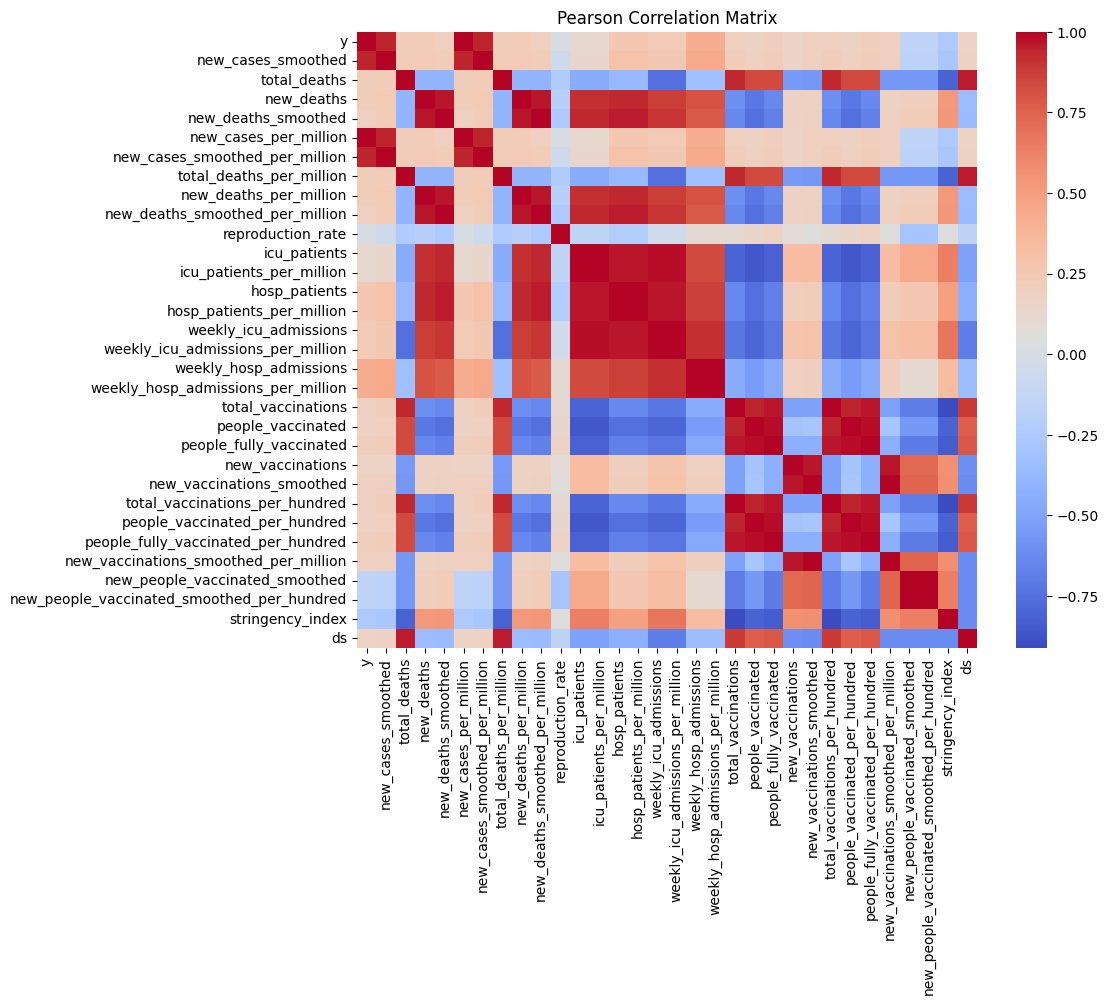

In [1524]:
# use Pearson and Spearman correaltion matrix to determine multicollinearity 
pearson_corr = train.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [1525]:
# multicollinearity comes from per_hundred, per_million
train = train.loc[:, ~train.columns.str.contains('per_hundred|per_million|total|smoothed')]
train.columns


Index(['y', 'new_deaths', 'reproduction_rate', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions', 'people_vaccinated',
       'people_fully_vaccinated', 'new_vaccinations', 'stringency_index',
       'ds'],
      dtype='object')

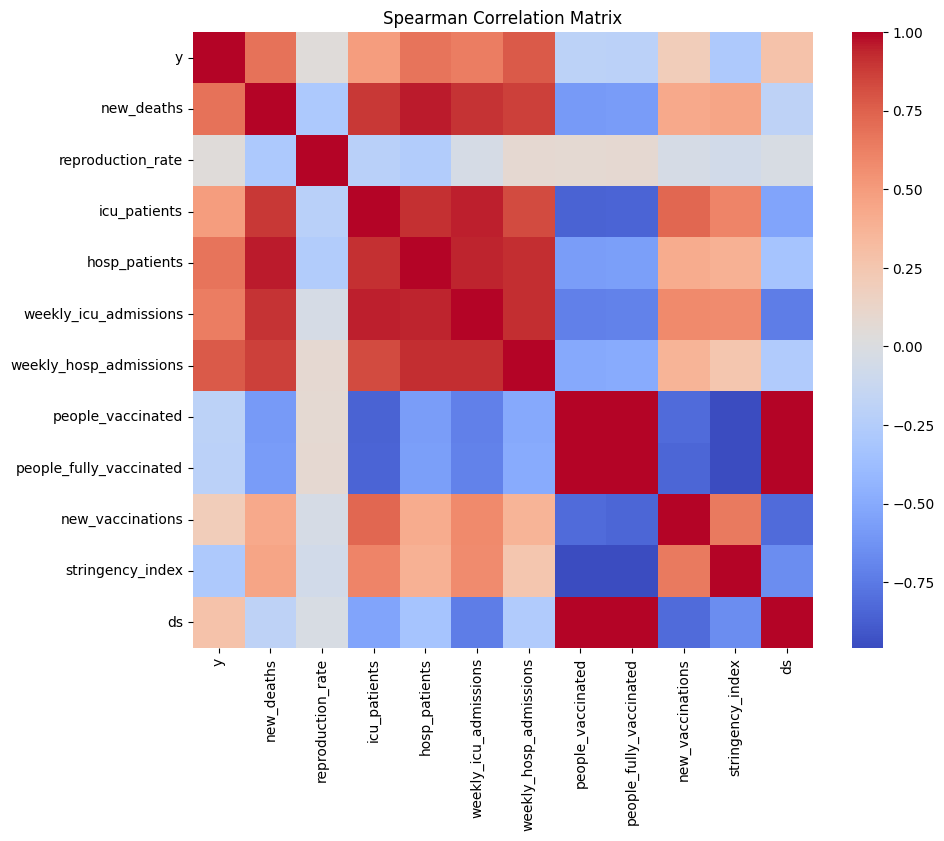

In [1526]:
spearman_corr = train.corr(method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

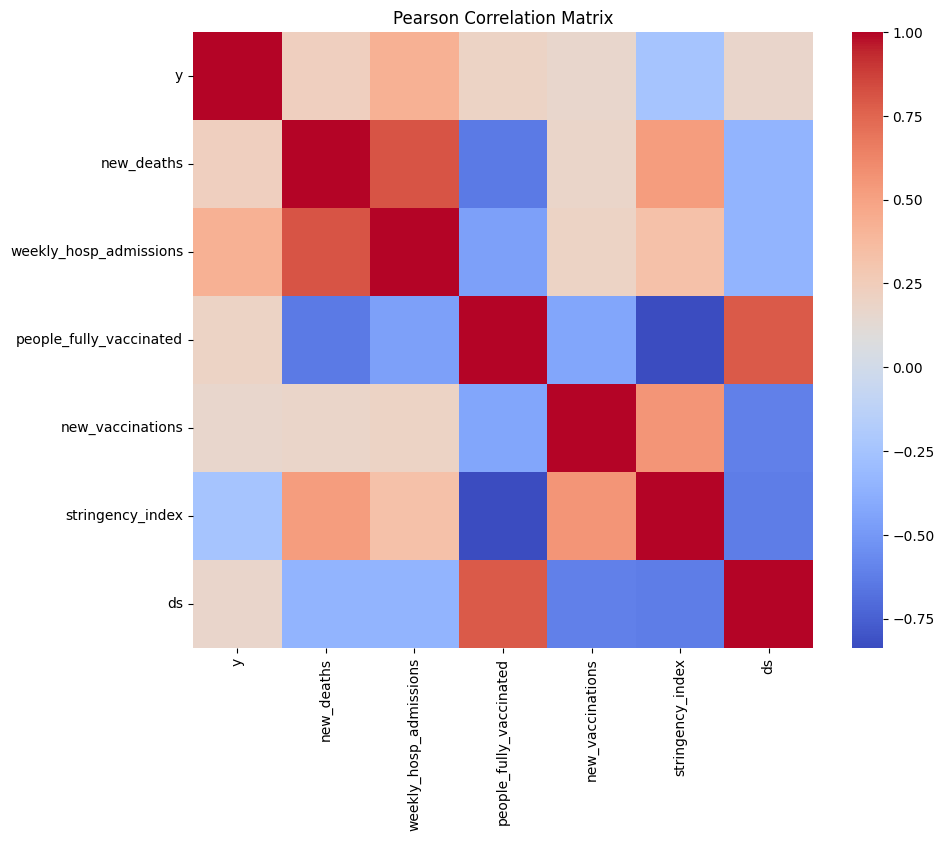

In [1527]:
train = train.drop(['weekly_icu_admissions', 'hosp_patients', 'icu_patients', 'people_vaccinated',
                    'reproduction_rate'], axis=1)
pearson_corr = train.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [1528]:
train = train.drop(['new_vaccinations'], axis=1)
train = train.drop(['stringency_index'], axis=1)

In [1529]:
train.columns

Index(['y', 'new_deaths', 'weekly_hosp_admissions', 'people_fully_vaccinated',
       'ds'],
      dtype='object')

In [1530]:
test = test.loc[:, ~test.columns.str.contains('per_hundred|per_million|total|smoothed')]
test = test.drop(['weekly_icu_admissions', 'hosp_patients', 'icu_patients', 'people_vaccinated',
                    'reproduction_rate', 'new_vaccinations', 'stringency_index'], axis=1)
test.columns

Index(['y', 'new_deaths', 'weekly_hosp_admissions', 'people_fully_vaccinated',
       'ds'],
      dtype='object')

## Feature Engineering

In [1531]:
# lagged features with new_cases, identified in autocorrelation graph
for lag in [1, 8]:
    train[f'y_lag{lag}'] = train['y'].shift(lag)
for lag in [1, 8]:
    test[f'y_lag{lag}'] = test['y'].shift(lag)
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    train[f'y_roll_mean{window}'] = train['y'].rolling(window=window).mean()
    train[f'y_roll_std{window}'] = train['y'].rolling(window=window).std()    
for window in [7, 14]:
    test[f'y_roll_mean{window}'] = test['y'].rolling(window=window).mean()
    test[f'y_roll_std{window}'] = test['y'].rolling(window=window).std()

In [1532]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [1533]:
#set outliers to NA
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['y'] < lower_bound) | (train['y'] > upper_bound)]

train.loc[train['y'] < lower_bound, 'y'] = None
train.loc[train['y'] > upper_bound, 'y'] = None

In [1534]:
train.isnull().sum()

y                          122
new_deaths                   0
weekly_hosp_admissions       0
people_fully_vaccinated      0
ds                           0
y_lag1                       0
y_lag8                       0
y_roll_mean7                 0
y_roll_std7                  0
y_roll_mean14                0
y_roll_std14                 0
dtype: int64

In [1535]:
# take into account holiday and incubation period
from prophet.make_holidays import make_holidays_df

us_holidays = make_holidays_df(
    year_list=[2020 + i for i in range(4)], country='US'
)
# italy had two lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-09', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-09', 'lower_window': 0, 'ds_upper': '2021-02-07'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
holidays = pd.concat((lockdowns, us_holidays))
holidays = holidays.reset_index()
holidays.loc[2:, 'ds_upper'] = holidays.loc[2:, 'ds'] + pd.Timedelta(days=7)
holidays.head()

,index,holiday,ds,lower_window,ds_upper,upper_window
0,0,lockdown_1,2020-03-09,0.0,2020-05-18,70.0
1,1,lockdown_2,2020-11-09,0.0,2021-02-07,90.0
2,0,Martin Luther King Jr. Day,2020-01-20,NaN,2020-01-27,NaN
3,1,Washington's Birthday,2020-02-17,NaN,2020-02-24,NaN
4,2,Columbus Day,2020-10-12,NaN,2020-10-19,NaN


## Model Development

In [1536]:
train['cap'] = 40000
test['cap'] = 40000
train['floor'] = 0
test['floor'] = 0

In [1537]:
train.columns

Index(['y', 'new_deaths', 'weekly_hosp_admissions', 'people_fully_vaccinated',
       'ds', 'y_lag1', 'y_lag8', 'y_roll_mean7', 'y_roll_std7',
       'y_roll_mean14', 'y_roll_std14', 'cap', 'floor'],
      dtype='object')

In [1538]:
# holidays
m = Prophet(growth='logistic',
            holidays=holidays,
            holidays_prior_scale = 20,
            seasonality_prior_scale = 1,
            changepoint_prior_scale = 0.005,
            seasonality_mode = 'multiplicative'
            )
for col in train.columns:
    if col not in ['ds', 'y', 'cap','floor']:
        m.add_regressor(col)
m.fit(train)

16:36:19 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing


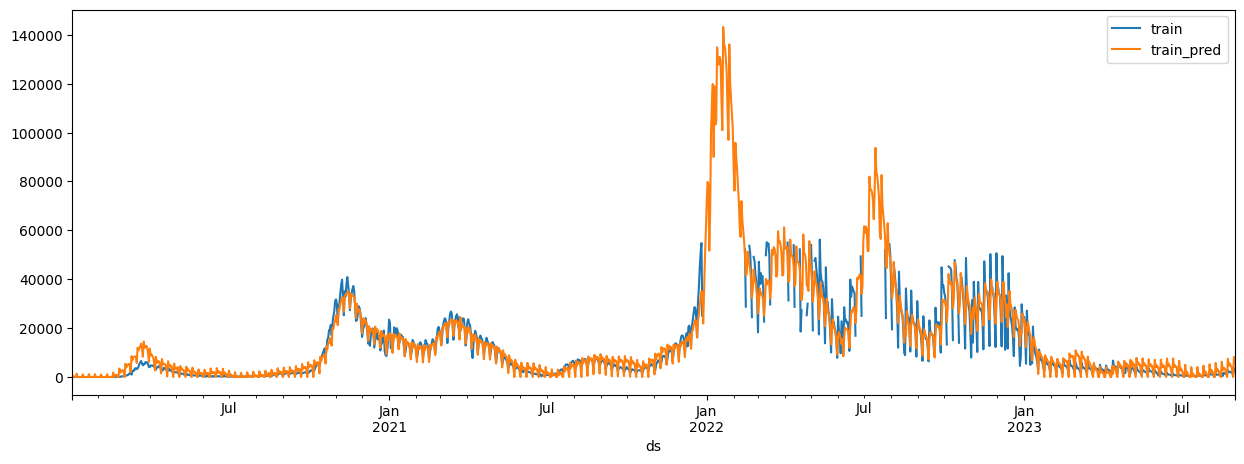

In [1548]:
train_pred=m.predict(train).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

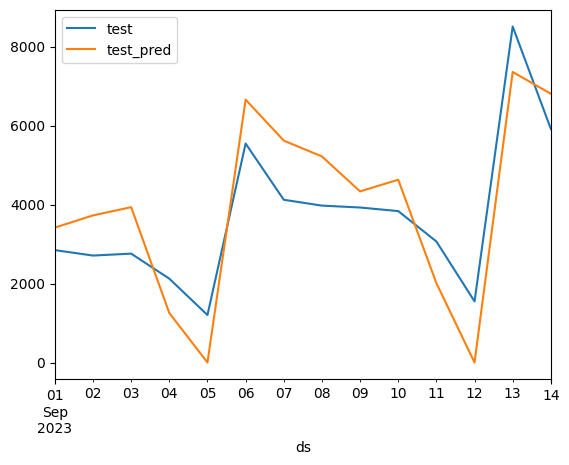

In [1549]:
test_pred=m.predict(test).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [1550]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 1082.5246012410234


## CV

In [1542]:
# #Parameter Grid
# from sklearn.model_selection import ParameterGrid
# from prophet.diagnostics import cross_validation, performance_metrics
# param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
#               'seasonality_prior_scale': [1, 5, 10, 20],
#               'holidays_prior_scale': [5, 10, 20, 25],
#               'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
# grid = ParameterGrid(param_grid)
# len(list(grid))

# #Store the results
# rmse = []
# #Loop
# for params in grid:
#   #model
#   m = Prophet(growth='logistic',
#               holidays = holidays,
#               seasonality_mode = params['seasonality_mode'],
#               seasonality_prior_scale = params['seasonality_prior_scale'],
#               holidays_prior_scale = params['holidays_prior_scale'],
#               changepoint_prior_scale = params['changepoint_prior_scale'])
#   for col in train.columns:
#     if col not in ['ds', 'y', 'cap','floor']:
#         m.add_regressor(col)
#   m.fit(train)


#   #CV
#   df_cv = cross_validation(m,
#                           horizon = '14 days',
#                           period = '100 days',
#                           initial = '365 days',
#                           parallel = 'processes')

#   #Measure the error and store the result
#   error = performance_metrics(df_cv)["rmse"].mean()
#   rmse.append(error)

In [1543]:
# tuning_results = pd.DataFrame(grid)
# tuning_results['rmse'] = rmse
# best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
# best_params

In [1551]:
m2 = Prophet(growth='logistic',
             holidays=holidays,
             holidays_prior_scale = 5,
             seasonality_prior_scale = 10,
             changepoint_prior_scale = 0.1,
             seasonality_mode = 'multiplicative'
             )
for col in train.columns:
    if col not in ['ds', 'y', 'cap', 'floor']:
        m2.add_regressor(col)
m2.fit(train)

16:37:56 - cmdstanpy - INFO - Chain [1] start processing
16:37:57 - cmdstanpy - INFO - Chain [1] done processing


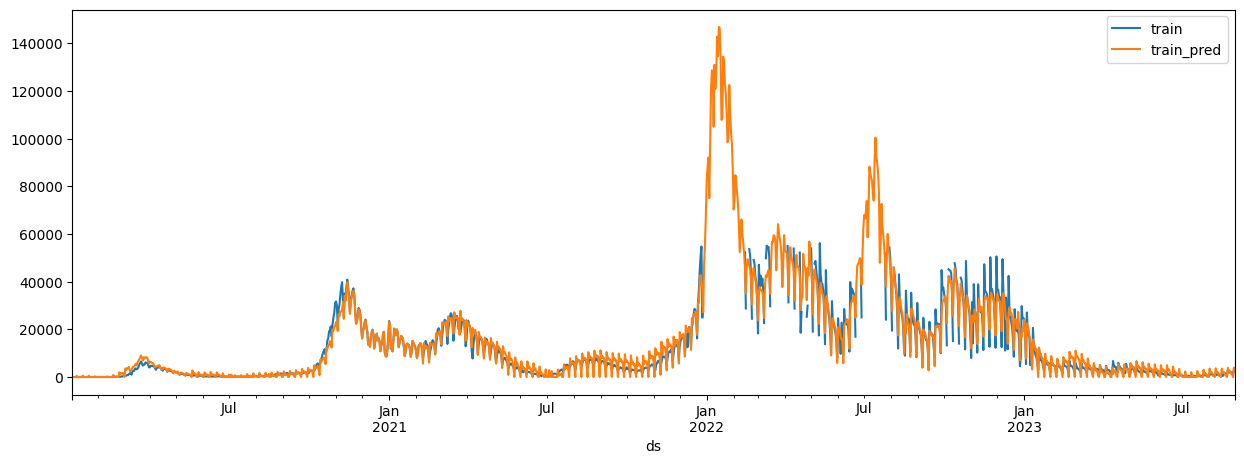

In [1552]:
train_pred=m2.predict(train).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

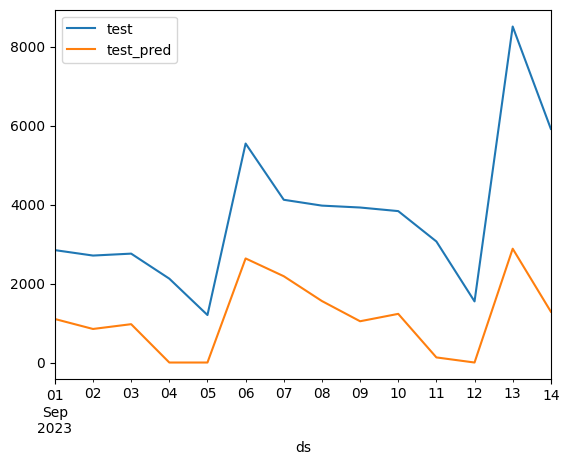

In [1553]:
test_pred=m2.predict(test).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [1554]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 2839.8261648652506
